<a href="https://colab.research.google.com/github/abhi9716/notebooks/blob/master/LSTM_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the Data

In [139]:
import pandas as pd
import numpy as np
opsd_daily = pd.read_csv('opsd_germany_daily.csv', index_col=0, parse_dates=True)
opsd_daily.shape

(4383, 4)

In [140]:
opsd_daily.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN


In [0]:
opsd_daily.Wind.fillna(opsd_daily.Wind.mean(),inplace=True)

opsd_daily.Solar.fillna(opsd_daily.Solar.mean(),inplace=True)
opsd_daily['Wind+Solar'].fillna(opsd_daily['Wind+Solar'].mean(),inplace=True)

# Data Cleaning

In [0]:
# drop Date that are NaN
opsd_daily = opsd_daily[pd.isna(opsd_daily.index)==False]
# drop if target value is NaN
opsd_daily = opsd_daily[pd.isna(opsd_daily['Consumption'])==False]

In [0]:
data=opsd_daily['Consumption']

In [0]:
# Let's load the required libs.
# We'll be using the Tensorflow backend (default).
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

In [145]:
# Get the raw data values from the pandas data frame.
data_raw = data.values.astype("float32").reshape(-1, 1)

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

# Print a few values.
dataset[0:5]

array([[0.26152682],
       [0.62055206],
       [0.6920625 ],
       [0.7089958 ],
       [0.73196006]], dtype=float32)

In [146]:
# Using 70% of data for training, 30% for validation.
TRAIN_SIZE = 0.70

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (3068, 1315)


In [0]:
# FIXME: This helper function should be rewritten using numpy's shift function. See below.
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [148]:
# Create test and training sets for one-step-ahead regression.
window_size = 7
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(3060, 7)
New training data shape:
(3060, 1, 7)


In [149]:
train_X

array([[[0.26152682, 0.62055206, 0.6920625 , ..., 0.73196006,
         0.6469667 , 0.52802837]],

       [[0.62055206, 0.6920625 , 0.7089958 , ..., 0.6469667 ,
         0.52802837, 0.4215883 ]],

       [[0.6920625 , 0.7089958 , 0.73196006, ..., 0.52802837,
         0.4215883 , 0.79214644]],

       ...,

       [[0.6786109 , 0.41987467, 0.3056345 , ..., 0.69960546,
         0.70904875, 0.7113217 ]],

       [[0.41987467, 0.3056345 , 0.6678841 , ..., 0.70904875,
         0.7113217 , 0.6774162 ]],

       [[0.3056345 , 0.6678841 , 0.69960546, ..., 0.7113217 ,
         0.6774162 , 0.41152465]]], dtype=float32)

In [0]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(40, 
                   input_shape = (1, window_size))) #(time_steps,input_size)=(1,7)
    
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 100, 
              batch_size = 100, 
              validation_data=(test_X, test_Y),
              verbose = 2)
    
    return(model)

# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

In [151]:
import math
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 76.12 RMSE
Test data score: 72.31 RMSE


In [152]:
train_predict.shape

(3060, 1)

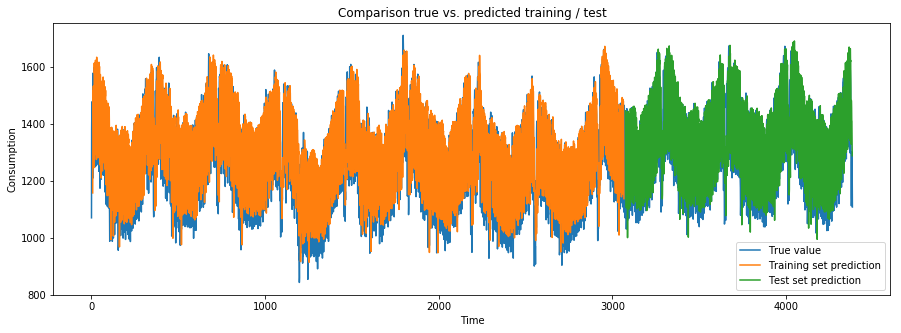

In [153]:
import matplotlib.pyplot as plt
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Time")
plt.ylabel("Consumption")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()


Using additional features for model training

In [0]:

import plotly.graph_objs as go
import numpy as np
import seaborn as sns

%matplotlib inline

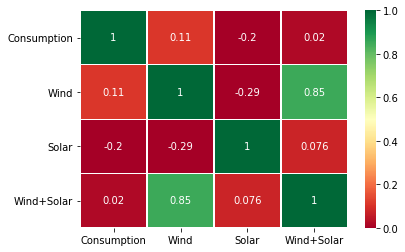

In [155]:
sns.heatmap(opsd_daily.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)


In [0]:


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg



In [0]:


scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(opsd_daily.values)



In [158]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)

reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t)
1,0.261527,0.193849,0.3643,0.302605,0.620552
2,0.620552,0.193849,0.3643,0.302605,0.692063
3,0.692063,0.193849,0.3643,0.302605,0.708996
4,0.708996,0.193849,0.3643,0.302605,0.731960
5,0.731960,0.193849,0.3643,0.302605,0.646967


In [159]:


values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



(3067, 1, 4) (3067,) (1315, 1, 4) (1315,)


In [0]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(50, 
                   input_shape = (train_X.shape[1], train_X.shape[2]))) #(time_steps,input_size)=(1,4)
    
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 100, 
              batch_size = 100, 
              validation_data=(test_X, test_y),
              verbose = 2)
    
    return(model)

# Fit the first model.
model2 = fit_model(train_X, train_y, window_size)

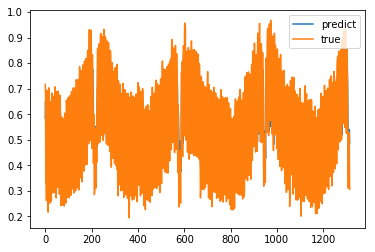

In [161]:
yhat = model2.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

In [0]:
from numpy import concatenate

#Scaler Inverse Y back to normal value
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [163]:
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 133.429
